<div align="center">
<h1>Stage 6: Spot Checking Algorithms</a></h1>
by Hongnan Gao
<br>
</div>

## Dependencies and Configuration

In [ ]:
# !pip install gcloud == 0.18.3
!pip install -q mlxtend==0.19.0
!pip install -q statsmodels==0.13.1

import copy
import csv
import logging
import random
from dataclasses import dataclass, field
from functools import wraps
from time import time
from typing import Any, Callable, Dict, List, Optional, Union, Tuple

import matplotlib.pyplot as plt
import mlxtend
import numpy as np
import pandas as pd
import seaborn as sns
from mlxtend.evaluate import bias_variance_decomp, paired_ttest_5x2cv
from scipy import stats
from sklearn import (base, decomposition, dummy, ensemble, feature_selection,
                     linear_model, metrics, model_selection, neighbors,
                     pipeline, preprocessing, svm, tree)
from statsmodels.regression.linear_model import OLS

     |████████████████████████████████| 1.3 MB 5.2 MB/s 
     |████████████████████████████████| 9.8 MB 1.3 MB/s 


In [ ]:
@dataclass
class config:
    raw_data: str = "https://storage.googleapis.com/reighns/reighns_ml_projects/docs/supervised_learning/classification/breast-cancer-wisconsin/data/raw/data.csv"
    processed_data: str = "https://storage.googleapis.com/reighns/reighns_ml_projects/docs/supervised_learning/classification/breast-cancer-wisconsin/data/processed/processed.csv"
    df_folds: str = "https://storage.googleapis.com/reighns/reighns_ml_projects/docs/supervised_learning/classification/breast-cancer-wisconsin/data/processed/df_folds.csv"
    train_size: float = 0.9
    seed: int = 1992
    num_folds: int = 5
    cv_schema: str = "StratifiedKFold"
    classification_type: str = "binary"
    
    target_col: List[str] = field(default_factory = lambda: ["diagnosis"])
    unwanted_cols : List[str] =  field(default_factory = lambda: ["id", "Unnamed: 32"])
    
    # Plotting
    colors : List[str] =field(default_factory = lambda: ["#fe4a49", "#2ab7ca", "#fed766", "#59981A"])
    cmap_reversed = plt.cm.get_cmap('mako_r')

    def to_dict(self) -> Dict:
        """Convert the config object to a dictionary.

        Returns:
            Dict: The config object as a dictionary.
        """
        return {
            "raw_data": self.raw_data,
            "processed_data": self.processed_data,
            "train_size": self.train_size,
            "seed": self.seed,
            "num_folds": self.num_folds,
            "cv_schema": self.cv_schema,
            "classification_type": self.classification_type,
            "target_col": self.target_col,
            "unwanted_cols": self.unwanted_cols,
            "colors": self.colors,
            "cmap_reversed": self.cmap_reversed
        }


    
#     spot_checking_boxplot = "../data/images/spot_checking_boxplot.png"
#     oof_confusion_matrix = "../data/images/oof_confusion_matrix.png"
#     final_train_confusion_matrix = "../data/images/final_train_confusion_matrix.png"
#     precision_recall_threshold_plot = "../data/images/precision_recall_threshold_plot.png"
#     roc_plot = "../data/images/roc_plot.png"
#     feature_importance = "../data/images/feature_importance.png"

In [ ]:
def set_seeds(seed: int = 1234) -> None:
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    
def init_logger(log_file: str = "info.log"):
    """
    Initialize logger.
    """
    logger = logging.getLogger(__name__)
    logger.setLevel(logging.INFO)
    stream_handler = logging.StreamHandler()
    stream_handler.setFormatter(logging.Formatter("%(asctime)s - %(message)s", datefmt= "%Y-%m-%d,%H:%M:%S"))
    file_handler = logging.FileHandler(filename=log_file)
    file_handler.setFormatter(logging.Formatter("%(asctime)s - %(message)s",  datefmt= "%Y-%m-%d,%H:%M:%S"))
    logger.addHandler(stream_handler)
    logger.addHandler(file_handler)
    return logger

In [ ]:
# Utils functions that we need

def variance_inflation_factor(exog, idx_kept, vif_idx):
    """Compute VIF for one feature.
    
    Args:
        exog (np.ndarray): Observations
        idx_kept (List[int]): Indices of features to consider
        vif_idx (int): Index of feature for which to compute VIF
    
    Returns:
        float: VIF for the selected feature
    """
    exog = np.asarray(exog)
    
    x_i = exog[:, vif_idx]
    mask = [col for col in idx_kept if col != vif_idx]
    x_noti = exog[:, mask]
    
    r_squared_i = OLS(x_i, x_noti).fit().rsquared
    vif = 1. / (1. - r_squared_i)
    
    return vif

class ReduceVIF(base.BaseEstimator, base.TransformerMixin):
    """The base of the class structure is implemented in https://www.kaggle.com/ffisegydd/sklearn-multicollinearity-class;
    I heavily modified the class such that it can take in numpy arrays and correctly implemented the fit and transform method.
    """

    def __init__(self, thresh=10, max_drop=20):
        self.thresh = thresh
        self.max_drop = max_drop
        self.column_indices_kept_ = []
        self.feature_names_kept_ = None

    def reset(self):
        """Resets the state of predictor columns after each fold."""

        self.column_indices_kept_ = []
        self.feature_names_kept_ = None

    def fit(self, X, y=None):
        """Fits the Recursive VIF on the training folds and save the selected feature names in self.feature_names

        Args:
            X ([type]): [description]
            y ([type], optional): [description]. Defaults to None.

        Returns:
            [type]: [description]
        """
        
        self.column_indices_kept_, self.feature_names_kept_ = self.calculate_vif(X)     
        
        return self

    def transform(self, X, y=None):
        """Transforms the Validation Set according to the selected feature names.

        Args:
            X ([type]): [description]
            y ([type], optional): [description]. Defaults to None.

        Returns:
            [type]: [description]
        """

        return X[:, self.column_indices_kept_]

    def calculate_vif(self, X: Union[np.ndarray, pd.DataFrame]):
        """Implements a VIF function that recursively eliminates features.

        Args:
            X (Union[np.ndarray, pd.DataFrame]): [description]

        Returns:
            [type]: [description]
        """
        feature_names = None
        column_indices_kept = list(range(X.shape[1]))
        
        if isinstance(X, pd.DataFrame):
            feature_names = X.columns

        dropped = True
        count = 0
        
        while dropped and count <= self.max_drop:
            dropped = False
            
            max_vif, max_vif_col = None, None
            
            for col in column_indices_kept:
                
                vif = variance_inflation_factor(X, column_indices_kept, col)
                
                if max_vif is None or vif > max_vif:
                    max_vif = vif
                    max_vif_col = col
            
            if max_vif > self.thresh:
                # print(f"Dropping {max_vif_col} with vif={max_vif}")
                column_indices_kept.remove(max_vif_col)
                
                if feature_names is not None:
                    feature_names.pop(max_vif_col)
                    
                dropped = True
                count += 1
                
        return column_indices_kept, feature_names

In [ ]:
config = config()
logger = init_logger()

In [ ]:
# set seeding for reproducibility
_ = set_seeds(seed = config.seed)

# read data
df_folds = pd.read_csv(config.df_folds)

In [ ]:
# Assign predictors and target accordingly
predictor_cols = df_folds.columns.to_list()[:-2]
target_col = config.target_col

## Spot Checking Algorithms

<div class="alert alert-success" role="alert">
    <b>Terminology Alert!</b> This method is advocated by <a href="https://machinelearningmastery.com/">Jason Brownlee PhD</a> and this serves as the first stage of my modelling process. We will rapidly test (spot check) different classifier algorithms, from <code>DummyClassifier</code>, to <code>LinearModel</code> to more sophisticated ensemble trees like <code>RandomForest</code>. 
</div>

---

I also note to the readers that we need to think of a few things when choosing the "optimal" machine learning algorithm:

- [No Lunch Free Theorem](https://en.wikipedia.org/wiki/No_free_lunch_theorem) intuitively says that no single optimization algorithm can work best in all situations. Therefore, spot checking can help us form a basis of which algorithm might work better in this particular scenario.
- [Occam's Razor](https://en.wikipedia.org/wiki/Occam%27s_razor) often appears in many Machine Learning textbook, and the narrative is that a simpler model more often times generalizes better than a complex model. This is not unfamiliar when we think of the bias-variance tradeoff, and that is why there is always a tradeoff that we must make.

## Say No to Data Leakage!

<div class="alert alert-block alert-danger">
<b>Say No to Data Leakage:</b> This has been emphasized throughout and we must be careful as we should never touch the test set when fitting the model. In fact, we should try our best to not <b>contaminate</b> our validation set as well.
    <li> This means that preprocessing steps such as <code>StandardScaling()</code> should only be fitted on the training data, and then apply the same transformation (mean and std) on the test data. In other words, do not apply scaling on the whole dataset before splitting. 
    <li> However, it is also equally important to take note <b>not to contaminate</b> our validation set, which is often overlooked, resulting in over optimistic results from model selection phase, but perform badly on unseen test set. As a result, when we use a 5 fold cross validation, we should be careful during fitting that the preprocessing steps are only applied on the training folds, and not on all 5 folds.
    <li> The same idea is also applied to our <code>ReduceVIF()</code> preprocessing step. We should also include this in our pipeline and not select the features outside the cross-validation loop.</li>
</div>   

---

Quoting from **[scikit-learn](https://scikit-learn.org/stable/common_pitfalls.html)**:

> Data leakage occurs when information that would not be available at prediction time is used when building the model. This results in overly optimistic performance estimates, for example from [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation), and thus poorer performance when the model is used on actually novel data, for example during production.

> A common cause is not keeping the test and train data subsets separate. Test data should never be used to make choices about the model. **The general rule is to never call fit on the test data.** While this may sound obvious, this is easy to miss in some cases, for example when applying certain pre-processing steps.

> Although both train and test data subsets should receive the same preprocessing transformation (as described in the previous section), it is important that these transformations are only learnt from the training data. For example, if you have a normalization step where you divide by the average value, the average should be the average of the train subset, not the average of all the data. If the test subset is included in the average calculation, information from the test subset is influencing the model.


---

<div class="alert alert-success" role="alert">
    <b>How to avoid Data Leakage?</b> We know the pitfalls of fitting on validation/test data, the natural question is how can we avoid it completely? You can code it up yourself, but as a starter, we can use scikit-learn's <code>Pipeline</code> object. My tips are as follows:
<li> Any preprocessing step must be done after splitting the whole dataset into train and test. If you are also using cross-validation, then we should only apply the preprocessing steps on the train set, and then use the metrics obtained from the train set to transform the validation set. You can see my pseudo-code below for a rough outline.
    <li> The <code>Pipeline</code> object of Scikit-Learn can help prevent data leakage.
</div>

## Pseudo-Code of Cross-Validation and Pipeline

The below outlines a pseudo code of the cross-validation scheme using `Pipeline` object. Note that I included the most outer loop, which is searching for hyperparameters.

- Define $G$ as the set of combination of hyperparamters. Define number of splits to be $K$.
- For each set of hyperparameter $z \in Z$:
    - for fold $j$ in K:
        - Set $F_{\text{train}}=\bigcup\limits_{i\neq k}^{K} F_{i}$
        - Set $F_{\text{val}} = F_{j}$ as the validation set
        - Perform Standard Scaling on $F_{\text{train}}$ and find the mean and std
        - Perform VIF recursively on $F_{\text{train}}$ and find the selected features
        - Transform $F_{\text{val}}$ using the mean and std found using $F_{\text{train}}$
        - Transform $F_{\text{val}}$ to have only the selected features from $F_{\text{train}}$
        - Train and fit on $F_{\text{train}}$ 
    - Evaluate the fitted parameters on $F_{\text{val}}$ to obtain $\mathcal{M}$

## Training Pipeline

### Make Pipeline

In [ ]:
# @ TODO: https://www.kaggle.com/kabure/predicting-house-prices-xgb-rf-bagging-reg-pipe
# Different models can potentially have different pre-processing steps, consider putting steps as a 
# passable list.

def make_pipeline(model: Callable) -> Callable:
    """Create a feature preparation pipeline for a model.

    Args:
        model (Callable): The model to be used.

    Returns:
        _pipeline (Callable): pipeline object
    """

    # Create a list of steps, note that some models may not need certain steps, and hence
    # may need an if-else here
    steps = list()
    # standardization
    steps.append(("standardize", preprocessing.StandardScaler()))
    # reduce VIF
    steps.append(("remove_multicollinearity", ReduceVIF(thresh=10)))

    # the model to be appended at the last step
    steps.append(("model", model))
    # create pipeline
    _pipeline = pipeline.Pipeline(steps=steps)
    return _pipeline

In [ ]:
classifiers = [
    # baseline model
    dummy.DummyClassifier(random_state=config.seed, strategy="stratified"),
    # linear model
    linear_model.LogisticRegression(random_state=config.seed, solver="liblinear"),
    # nearest neighbours
    neighbors.KNeighborsClassifier(n_neighbors=8),
    # SVM
    svm.SVC(probability=True, random_state=config.seed),
    # tree
    tree.DecisionTreeClassifier(random_state=config.seed),
    # ensemble
    ensemble.RandomForestClassifier(n_estimators=10, random_state=config.seed),
]

classifiers = [make_pipeline(model) for model in classifiers]

### Results Class

The `Results` class will help us store model's results.

!!! danger "Careful when using ROC function!"
    
We also note that when passing arguments to scikit-learn's <code>roc_auc_score</code> function, we should be careful not to pass <code>y_score=model.predict(X)</code> inside as we have to understand that we are passing in <b>non-thresholded</b> probabilities into <code>y_score</code>. If you pass the predicted values (full of 0 and 1s), then you are thresholding on 0 and 1 only, which is incorrect by definition. 
</div>


In [ ]:
default_result_names = ["y_true", "y_pred", "y_prob"]

default_logit_names = ["y_true", "y_pred", "y_prob"]

default_score_names = [
    "accuracy_score",
    "precision_recall_fscore_support",
    "confusion_matrix",
    # "average_precision_score",
    "multiclass_roc_auc_score",
    "brier_score_loss",
]

custom_score_names = ["multiclass_roc_auc_score", "brier_score_loss"]

use_preds = [
    "accuracy_score",
    "precision_recall_fscore_support",
    "confusion_matrix",
]
use_probs = ["average_precision_score"]

In [ ]:
class Results:
    """Stores results for model training in columnwise format."""
    
    _result_dict: Dict
        
    logit_names: List[str]
    score_names: List[str]
        
    def __init__(
        self,
        logit_names: List[str] = default_logit_names,
        score_names: List[str] = default_score_names,
        existing_dict: Optional[Dict] = None,
    ):
        """Construct a new results store."""       
        self.logit_names = logit_names
        self.score_names = score_names
        
        if existing_dict is not None:
            self._result_dict = copy.deepcopy(existing_dict)
            return
        
        dict_keys = ["identifier", *logit_names, *score_names]
        
        self._result_dict = {
            key: [] for key in dict_keys
        }
    
    def add(self, identifier: str, results: Dict, in_place=False):
        """Add a new results row."""        
        if not in_place:
            return Results(
                self.logit_names,
                self.score_names,
                self._result_dict
            ).add(identifier, results, in_place=True)
        
        self._result_dict["identifier"].append(identifier)
        
        for result_name in set([*results.keys(), *self.logit_names, *self.score_names]):
            
            result_value = results.get(result_name, np.nan)
            
            self._result_dict[result_name].append(result_value)
        
        return self
    
    def get_result(self, result_name: str) -> Dict[str, Any]:
        """Get a map of identifiers to result values for a result."""
        return {
            identifier: result_value for
            identifier, result_value in
            zip(self._result_dict["identifier"], self._result_dict[result_name])
        }
    
    def get_result_values(self, result_name: str) -> List[Any]:
        """Get a list of values for a result."""
        return self._result_dict[result_name]
    
    def to_dataframe(self) -> pd.DataFrame:
        """Get a Data Frame containing the results."""
        return pd.DataFrame.from_dict(self._result_dict)
    
    def to_dict(self) -> Dict:
        """Get a dictionary containing the results.
        
        Returns:
             Dict[str, List[Any]]: Dictionary of result columns 
        """
        return self._result_dict

In [ ]:
def multiclass_label_binarize(
    y: np.ndarray, class_labels: List[int], pos_label=1, neg_label=0
):
    """Binarize labels in one-vs-all fashion.
    # TODO: to replace with the above vstack method.

    Args:
        y (np.ndarray) Sequence of integer labels to encode
        class_labels (array-like) Labels for each class
        pos_label (int) Value for positive labels
        neg_label (int) Value for negative labels
    Returns:
        np.ndarray of shape (n_samples, n_classes) Encoded dataset
    """
    if isinstance(y, list):
        y = np.asarray(y)

    columns = [
        np.where(y == label, pos_label, neg_label) for label in class_labels
    ]

    return np.column_stack(columns)


def multiclass_roc_auc_score(y_true, y_score, classes=None):
    """Compute ROC-AUC score for each class in a multiclass dataset.
    
    Args:
        y_true (np.ndarray of shape (n_samples, n_classes)) True labels
        y_score (np.ndarray of shape (n_samples, n_classes)) Target scores
        classes (array-like of shape (n_classes,)) List of dataset classes. If `None`,
            the lexicographical order of the labels in `y_true` is used.
    
    Returns:
        array-like: ROC-AUC score for each class, in the same order as `classes`
    """
    classes = (
        np.unique(y_true) if classes is None
        else classes
    )
    
    y_true_multiclass = multiclass_label_binarize(
        y_true,
        class_labels=classes
    )
    
    def oneclass_roc_auc_score(class_id):
        y_true_class = y_true_multiclass[:, class_id]
        y_score_class = y_score[:, class_id]
        
        fpr, tpr, _ = metrics.roc_curve(
            y_true=y_true_class,
            y_score=y_score_class,
            pos_label=1
        )
        
        return metrics.auc(
            fpr,
            tpr
        )
    
    return [
        oneclass_roc_auc_score(class_id)
        for class_id in range(len(classes))
    ]

### Utilities 

Some utility functions to prepare data and post-process data.

In [ ]:
def prepare_y(y: np.ndarray) -> np.ndarray:
    """Prepare the target variable for the model.

    If Binary Classification, we need to ravel the array to 1d.

    Args:
        y (np.ndarray): Target variable.

    Returns:
        np.ndarray: Transformed Target variable.
    """
    return y.ravel() if config.classification_type == "binary" else y

def mean_score(score_values) -> Union[float, np.ndarray]:
    """Compute the mean score."""
    
    score_values = np.array(score_values)
    
    shape = score_values.shape
    
    if len(shape) == 1:
        return score_values.mean()
    
    return score_values.mean(axis=0)

def mean_cv_results(model_results: Results) -> Dict:
    """Add mean cross-validation results.
    
    This method computes the mean value for all
    score types in the model_results, including
    for scores (e.g., confusion matrix) where
    the mean value may contain decimal places.
    """
    cv_logits = {
        y_result: np.concatenate(model_results.get_result_values(y_result))
        for y_result in
        model_results.logit_names
    }
    
    cv_scores = {
        score: mean_score(
            model_results.get_result_values(score)
        )
        for score in model_results.score_names
    }
    
    return {
        **cv_logits,
        **cv_scores,
    }

def oof_cv_results(model_results: Results) -> Dict:
    """Add OOF cross-validation results."""
    
    cv_logits = {
        y_result: np.concatenate(
            model_results.get_result_values(y_result)
        )
        for y_result in
        model_results.logit_names
    }
    
    cv_scores = compute_metrics(cv_logits)
    
    return {
        **cv_logits,
        **cv_scores,
    }

def add_cv_results(model_results: Results):
    """Add cross-validation results.
    
    This method returns a copy of the given model results
    with summary columns for mean and CV cross-validation.
    """
    mean_cv = mean_cv_results(model_results)
    oof_cv = oof_cv_results(model_results)
    
    return (
        model_results
        .add("mean_cv", mean_cv)
        .add("oof_cv", oof_cv)
    )

In [ ]:
def compute_metrics(logits: Dict[str, np.ndarray]) -> Dict[str, Any]:
    """Compute metrics from logits.
    use_probs: all metrics that use probabilities.
    use_preds: all metrics that use thresholded predictions.
    
    # TODO add this
    precision, recall, fbeta_score, _ = metrics.precision_recall_fscore_support(
        y_true=y_val,
        y_pred = y_val_pred,
        labels=np.unique(y_val),
        average=None
    )
    """

    y_true, y_pred, y_prob = (
        logits["y_true"],
        logits["y_pred"],
        logits["y_prob"],
    )


    use_preds = [
        "accuracy_score",
        "precision_recall_fscore_support",
        "confusion_matrix",
    ]
    use_probs = ["average_precision_score"]

    default_metrics_dict: Dict[str, float] = {}
    custom_metrics_dict: Dict[str, float] = {}

    for metric_name in default_score_names:
        if hasattr(metrics, metric_name):
            # TODO: get metric score with default parameters, consider adding kwargs if you want to configure parameters
            if metric_name in use_preds:
                metric_score = getattr(metrics, metric_name)(
                    y_true, y_pred
                )
            elif metric_name in use_probs:
                # logger.info("TODO: write custom scores for precision-recall as here is hardcoded")
                pass
#                 metric_score = getattr(metrics, metric_name)(
#                     y_true, y_prob
#                 )
        else:
            # add custom metrics here
            multiclass_roc_auc = multiclass_roc_auc_score(y_true, y_prob)
            brier_score_loss = (
                metrics.brier_score_loss(y_true=y_true, y_prob=y_prob[:, 1])
                if config.classification_type == "binary"
                else np.nan
            )
            custom_metrics_dict["multiclass_roc_auc_score"] = multiclass_roc_auc
            custom_metrics_dict["brier_score_loss"] = brier_score_loss

        if metric_name not in default_metrics_dict:
            default_metrics_dict[metric_name] = metric_score

        metrics_dict = {**default_metrics_dict, **custom_metrics_dict}

    return metrics_dict

In [ ]:
def train_on_fold(
    df_folds: pd.DataFrame,
    models: List[Callable],
    num_folds: int,
    predictor_col: List[str],
    target_col: List[str],
) -> Dict[str, List]:
    """Take in a dataframe with fold number as column,
    and a models which holds a list of callable models,
    we will loop through and return a dictionary of cv results.

    Args:
        df_folds (pd.DataFrame): Dataframe with fold number as column.
        model (Callable): A callable model.
        num_folds (int): Number of folds.
        predictor_col (List[str]): List of predictor columns.
        target_col (List[str]): List of target columns.


    Returns:
        model_dict (Dict[str, Results]: Dictionary of model results with model name as key.
    """

    y_true = df_folds[target_col].values.flatten()

    # test_pred_arr: np.ndarray = np.zeros(len(X_test))

    model_dict = {}

    for model in models:
        model_results = Results()

        if isinstance(model, pipeline.Pipeline):
            model_name = model["model"].__class__.__name__
        else:
            model_name = model.__class__.__name__

        # out-of-fold validation predictions
        oof_pred_arr: np.ndarray = np.zeros(len(df_folds))

        for fold in range(1, num_folds + 1):

            train_df = df_folds[df_folds["fold"] != fold].reset_index(drop=True)
            val_df = df_folds[df_folds["fold"] == fold].reset_index(drop=True)
            val_idx = df_folds[df_folds["fold"] == fold].index.values
            X_train, y_train = train_df[predictor_col].values, prepare_y(
                train_df[target_col].values
            )
            X_val, y_val = val_df[predictor_col].values, prepare_y(
                val_df[target_col].values
            )

            model.fit(X_train, y_train)
            y_val_pred = model.predict(X_val)
            y_val_prob = model.predict_proba(X_val)

            logits = {
                "y_true": y_val,
                "y_pred": y_val_pred,
                "y_prob": y_val_prob,
            }

            metrics = compute_metrics(logits)

            model_results.add(f"fold {fold}", {**logits, **metrics}, in_place=True)

        if model_name not in model_dict:
            model_dict[model_name] = model_results

    return model_dict


In [ ]:
# Returns a dict in the format of
# {'LogisticRegression': <__main__.Results at 0x7f3bca575e90>}
model_dict = train_on_fold(
    df_folds,
    models = classifiers,
    num_folds=5,
    predictor_col=predictor_cols,
    target_col = config.target_col
)

In [ ]:
# Takes in a model_dict and add cv results to the dict
model_dict_with_summary = {
    model: add_cv_results(model_results)
    for model, model_results in model_dict.items()
}

In [ ]:
# Transforms model_dict_with_summary to a Dict of dataframes
# model_results_df['LogisticRegression'] -> df
model_results_df = {
    name: results.to_dataframe().T for name, results in model_dict_with_summary.items()
}

In [ ]:
results_df = pd.concat(model_results_df, axis=0)
results_df.columns = ['fold 1', 'fold 2', 'fold 3', 'fold 4', 'fold 5', 'mean_cv', 'oof_cv']
results_df.tail()

fold 1  ...                                             oof_cv
RandomForestClassifier accuracy_score                                                            0.932039  ...                                           0.951172
                       precision_recall_fscore_support  ([0.9672131147540983, 0.8809523809523809], [0....  ...  ([0.9484848484848485, 0.9560439560439561], [0....
                       confusion_matrix                                                [[59, 5], [2, 37]]  ...                              [[313, 8], [17, 174]]
                       multiclass_roc_auc_score                  [0.9709535256410255, 0.9709535256410255]  ...           [0.9849374500497463, 0.9849374500497464]
                       brier_score_loss                                                         0.0594175  ...                                          0.0429688

[5 rows x 7 columns]

### Comparison of Cross-Validated Models (CV + OOF)

The point of the following comparison is to check how different models are performing across folds. More specifically, if we have 5 folds, we will have a metric score for each fold, subsequently, we can find the standard error of model's performance. We need to be aware of models that have high variance across folds in terms of the metrics performance. This can indicate that the model is highly unstable, and may be a sign of overfitting.

In [ ]:
def summarize_metrics(
    model_dict: Dict[str, Results], metric_name: str = "roc", pos_label: int = 1
):
    """
    Summarize metrics of each fold with its standard error.
    We also plot a boxplot to show the results.
    """

    results = []

    for model_name, model_results in model_dict.items():
        result_dict = model_results.get_result(result_name=metric_name)

        tmp_score = []
        for fold, metric in result_dict.items():
            pos_class_score = metric[pos_label]
            results.append((model_name, fold, pos_class_score))
            tmp_score.append(pos_class_score)

        # append the Standard Error of K folds
        results.append(
            (model_name, "SE", np.std(tmp_score, ddof=1) / len(tmp_score) ** 0.5)
        )

    summary_df = pd.DataFrame(results, columns=["model", "fold", metric_name])

    fig, ax = plt.subplots(figsize=(15, 8))
    _ = sns.boxplot(
        x="model",
        y=metric_name,
        data=summary_df[
            (summary_df["model"] != "DummyClassifier") & (summary_df["fold"] != "SE")
        ],
        ax=ax,
    )

    # fig.savefig(config.spot_checking_boxplot, format='png', dpi=300)

    return summary_df


,model,fold,multiclass_roc_auc_score
24,DecisionTreeClassifier,fold 1,0.865585
25,DecisionTreeClassifier,fold 2,0.924291
26,DecisionTreeClassifier,fold 3,0.923931
27,DecisionTreeClassifier,fold 4,0.923931
28,DecisionTreeClassifier,fold 5,0.895148
29,DecisionTreeClassifier,SE,0.011677
30,RandomForestClassifier,fold 1,0.970954
31,RandomForestClassifier,fold 2,0.989676
32,RandomForestClassifier,fold 3,0.996711
33,RandomForestClassifier,fold 4,0.993010


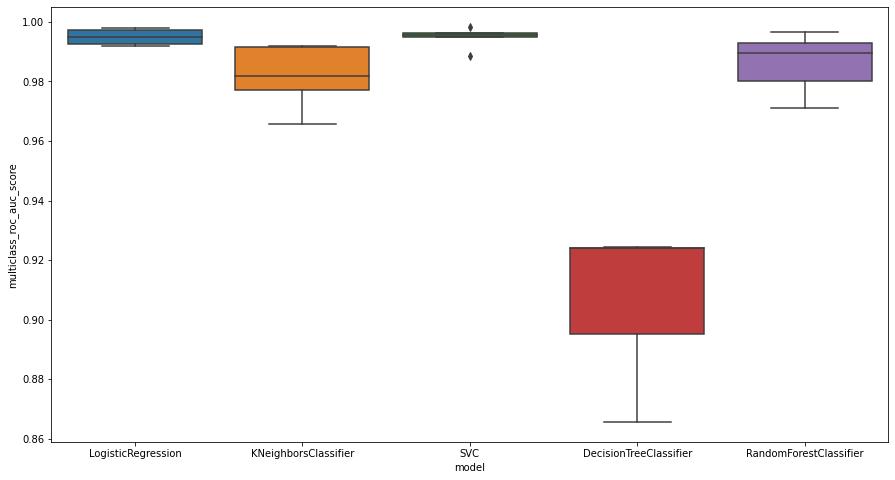

In [ ]:
summary_df = summarize_metrics(
    model_dict=model_dict, metric_name="multiclass_roc_auc_score"
)
display(summary_df.tail(12))

### Out-of-Fold Confusion Matrix

We do have information on the performance of each folds, we now look at the performance of all 5 folds together. Typicall there are two ways to do it, one is to simply take the average of the score of five folds, the other is to take a look at out of folds predictions.

---

From the confusion matrix of the out of fold performance, Logistic Regression does seem to be a model we can explore on, although slightly lower in terms of overall AUROC score than SVC, it seems to have the quite low False Negatives amongst all. With further hyperparameter tuning and threshold optimization, we can make it better.

In [ ]:
model_names = [model for model in model_dict.keys()]

In [ ]:
def plot_binary_confusion_matrix(
    results_df: pd.DataFrame, model_names: List[str]
) -> None:

    n_models = len(model_names)
    # if 7 models, then 3 rows, 2 columns, and 7 subplots
    # always fix column to be 3
    n_cols = 3
    n_rows = int(np.ceil(n_models / n_cols))

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(10, 10))

    for axes, algo in zip(ax.ravel(), model_names):
        # Unravel into tn, fp, fn and tp
        tn, fp, fn, tp = results_df.oof_cv[algo].confusion_matrix.ravel()
        # reshape into tp, fp, fn, tn - this is personal preference
        reshaped_cm = np.asarray([[tp, fp], [fn, tn]])

        # Get positive ROC score - hardcoded here.
        positive_class_auroc = results_df.oof_cv[algo].multiclass_roc_auc_score[1]

        # annotations
        labels = ["True Pos", "False Pos", "False Neg", "True Neg"]
        counts = ["{0:0.0f}".format(value) for value in reshaped_cm.flatten()]
        percentages = [
            "{0:.2%}".format(value)
            for value in reshaped_cm.flatten() / np.sum(reshaped_cm)
        ]

        # final annotations
        label = (
            np.array(
                [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(labels, counts, percentages)]
            )
        ).reshape(2, 2)

        # heatmap
        sns.heatmap(
            data=reshaped_cm,
            vmin=0,
            vmax=330,
            cmap=["#fe4a49", "#2ab7ca", "#fed766", "#59981A"],
            linewidth=2,
            linecolor="white",
            square=True,
            ax=axes,
            annot=label,
            fmt="",
            cbar=False,
            annot_kws={"size": 10, "color": "black", "weight": "bold", "alpha": 0.8},
            alpha=1,
        )

        axes.text(
            0, -0, "{}".format(algo), {"size": 12, "color": "black", "weight": "bold"}
        )

        axes.scatter(1, 1, s=3500, c="white")
        axes.text(
            0.72,
            1.0,
            "AUC: {}".format(np.round(positive_class_auroc, 3)),
            {"size": 10, "color": "black", "weight": "bold"},
        )

        ## ticks and labels
        axes.set_xticklabels("")
        axes.set_yticklabels("")

    ## titles and text
    fig.text(
        0, 1.05, "Out Of Fold Confusion Matrix", {"size": 22, "weight": "bold"}, alpha=1
    )
    fig.text(
        0,
        1,
        """This Visualization show the results of various classifiers and there respective
    results.""",
        {"size": 14, "weight": "normal"},
        alpha=0.98,
    )

    fig.tight_layout(pad=2.5, w_pad=2.5, h_pad=2.5)
    # fig.savefig(config.oof_confusion_matrix, format='png', dpi=300)


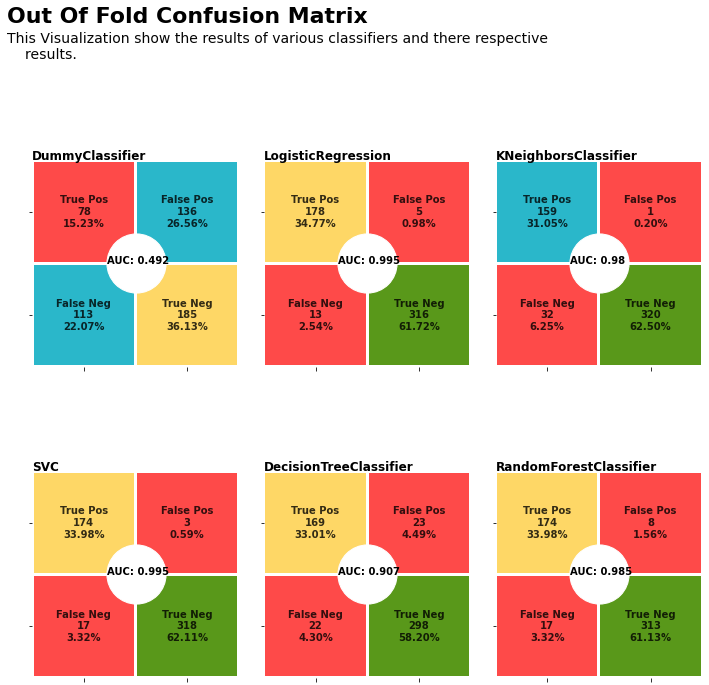

In [ ]:
plot_binary_confusion_matrix(results_df, model_names)

### Hypothesis Testing Across Models

I am slightly shocked at the performance of plain LogisticRegression, I decide to use an idea from [Hypothesis Testing Across Models](http://rasbt.github.io/mlxtend/user_guide/evaluate/paired_ttest_kfold_cv/) to check if the difference is really by chance or not. Note that I will be modifying his code as his code does not split using StratifiedKFold.

---

The basic idea is to test if two model's difference in scores (in this case roc), is statistically significant or not. However, we note that this method may violate an assumption of Student's t test.

---

- Null Hypothesis $H_0$: The difference in the performance score of two classifiers is Statistically Significant.
- Alternate Hypothesis $H_1$: The difference in the performance score of two classifiers is **not** Statistically Significant.

In [ ]:
def paired_ttest_skfold_cv(
    estimator1: Callable,
    estimator2: Callable,
    X: np.ndarray,
    y: np.ndarray,
    cv: int = 10,
    scoring: str = None,
    shuffle: bool = False,
    random_seed: int = None,
) -> float:
    """Modified from https://github.com/rasbt/mlxtend/blob/master/mlxtend/evaluate/ttest.py to accomodate StratifiedKFold.

    Args:
        estimator1 (Callable): [description]
        estimator2 (Callable): [description]
        X (np.ndarray): [description]
        y (np.ndarray): [description]
        cv (int, optional): [description]. Defaults to 10.
        scoring (str, optional): [description]. Defaults to None.
        shuffle (bool, optional): [description]. Defaults to False.
        random_seed (int, optional): [description]. Defaults to None.

    Raises:
        AttributeError: [description]

    Returns:
        float: [description]
    """
    if not shuffle:
        skf = model_selection.StratifiedKFold(n_splits=cv, shuffle=shuffle)
    else:
        skf = model_selection.StratifiedKFold(
            n_splits=cv, random_state=random_seed, shuffle=shuffle
        )

    if scoring is None:
        if estimator1._estimator_type == "classifier":
            scoring = "accuracy"
        elif estimator1._estimator_type == "regressor":
            scoring = "r2"
        else:
            raise AttributeError("Estimator must " "be a Classifier or Regressor.")
    if isinstance(scoring, str):
        scorer = metrics.get_scorer(scoring)
    else:
        scorer = scoring

    score_diff = []

    for train_index, test_index in skf.split(X=X, y=y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        estimator1.fit(X_train, y_train)
        estimator2.fit(X_train, y_train)

        est1_score = scorer(estimator1, X_test, y_test)
        est2_score = scorer(estimator2, X_test, y_test)
        score_diff.append(est1_score - est2_score)

    avg_diff = np.mean(score_diff)

    numerator = avg_diff * np.sqrt(cv)
    denominator = np.sqrt(
        sum([(diff - avg_diff) ** 2 for diff in score_diff]) / (cv - 1)
    )
    t_stat = numerator / denominator

    pvalue = stats.t.sf(np.abs(t_stat), cv - 1) * 2.0
    return float(t_stat), float(pvalue)


In [ ]:
# check if difference between algorithms is real
X_tmp = df_folds[predictor_cols].values
y_tmp = df_folds['diagnosis'].values

t, p = paired_ttest_skfold_cv(estimator1=classifiers[1], estimator2=classifiers[-1],shuffle=True,cv=5, X=X_tmp, y=y_tmp, scoring='roc_auc', random_seed=config.seed)

In [ ]:
logger.info('P-value: %.3f, t-Statistic: %.3f' % (p, t))

2021-11-13,14:04:35 - P-value: 0.171, t-Statistic: 1.667
2021-11-13,14:04:35 - P-value: 0.171, t-Statistic: 1.667


Since $p$-value is quite high, and more the basic threshold of 0.05 or 0.1, we fail to reject the null hypothesis, and say that there is no significant difference between these two models.